In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
dataset_path = '/content/Twitter_Data.csv'
df = pd.read_csv(dataset_path)
df


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [3]:
df = df. dropna ()


In [4]:
def text_normalize(text):
    # Chuyển chữ thường
    text = text.lower()

    # Loại bỏ từ "RT" (Retweet)
    text = re.sub(r'^rt[\s]+', '', text)

    # Loại bỏ liên kết
    text = re.sub(r'https?://.*[\r\n]*', '', text)

    # Loại bỏ dấu câu
    text = re.sub(r'[^\w\s]', '', text)

    # Loại bỏ stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)

    # Stemming
    stemmer = SnowballStemmer('english')
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words)

    return text


In [5]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['clean_text']).toarray()


In [17]:
intercept = np.ones((X.shape[0], 1))
X_b = np.concatenate((intercept, X), axis=1)


In [19]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Mã hóa nhãn thành các giá trị từ 0 đến n_classes - 1
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category'])

# Chuyển đổi nhãn thành one-hot encoding
onehot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = onehot_encoder.fit_transform(y.reshape(-1, 1))


In [20]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

# Chia dữ liệu thành tập train và validation
X_train, X_val, y_train, y_val = train_test_split(
    X_b, y_encoded,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

# Chia dữ liệu còn lại thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)


In [21]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / exp_z.sum(axis=1)[:, None]

def compute_loss(y_hat, y):
    n = y.size
    return (-1 / n) * np.sum(y * np.log(y_hat))

def predict(X, theta):
    z = np.dot(X, theta)
    y_hat = softmax(z)
    return y_hat

def compute_gradient(X, y, y_hat):
    n = y.size
    return np.dot(X.T, (y_hat - y)) / n

def update_theta(theta, gradient, lr):
    return theta - lr * gradient

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)
    acc = (np.argmax(y_hat, axis=1) == np.argmax(y, axis=1)).mean()
    return acc


In [22]:
lr = 0.1  # Learning rate
epochs = 200  # Số lượng epoch
batch_size = X_train.shape[0]  # Batch size được đặt bằng số mẫu trong tập train
n_features = X_train.shape[1]  # Số lượng đặc trưng

np.random.seed(random_state)
theta = np.random.uniform(size=(n_features, n_classes))


In [24]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i+batch_size]
        y_i = y_train[i:i+batch_size]

        # Dự đoán
        y_hat = predict(X_i, theta)

        # Tính loss và gradient
        train_loss = compute_loss(y_hat, y_i)
        gradient = compute_gradient(X_i, y_i, y_hat)

        # Cập nhật trọng số
        theta = update_theta(theta, gradient, lr)

        # Lưu lại loss và độ chính xác của batch
        train_batch_losses.append(train_loss)
        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

    # Tính loss và độ chính xác trên tập validation
    y_val_hat = predict(X_val, theta)
    val_loss = compute_loss(y_val_hat, y_val)
    val_acc = compute_accuracy(X_val, y_val, theta)
    val_batch_losses.append(val_loss)
    val_batch_accs.append(val_acc)

    # Tính trung bình loss và accuracy cho toàn bộ epoch
    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    # Lưu lại kết quả của epoch
    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    # In kết quả của epoch hiện tại
    print(f'\nEPOCH {epoch + 1}: Training loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')



EPOCH 1: Training loss: 0.368	Validation loss: 0.367

EPOCH 2: Training loss: 0.368	Validation loss: 0.367

EPOCH 3: Training loss: 0.368	Validation loss: 0.367

EPOCH 4: Training loss: 0.368	Validation loss: 0.367

EPOCH 5: Training loss: 0.368	Validation loss: 0.367

EPOCH 6: Training loss: 0.367	Validation loss: 0.367

EPOCH 7: Training loss: 0.367	Validation loss: 0.366

EPOCH 8: Training loss: 0.367	Validation loss: 0.366

EPOCH 9: Training loss: 0.367	Validation loss: 0.366

EPOCH 10: Training loss: 0.367	Validation loss: 0.366

EPOCH 11: Training loss: 0.367	Validation loss: 0.366

EPOCH 12: Training loss: 0.367	Validation loss: 0.366

EPOCH 13: Training loss: 0.366	Validation loss: 0.366

EPOCH 14: Training loss: 0.366	Validation loss: 0.365

EPOCH 15: Training loss: 0.366	Validation loss: 0.365

EPOCH 16: Training loss: 0.366	Validation loss: 0.365

EPOCH 17: Training loss: 0.366	Validation loss: 0.365

EPOCH 18: Training loss: 0.366	Validation loss: 0.365

EPOCH 19: Training

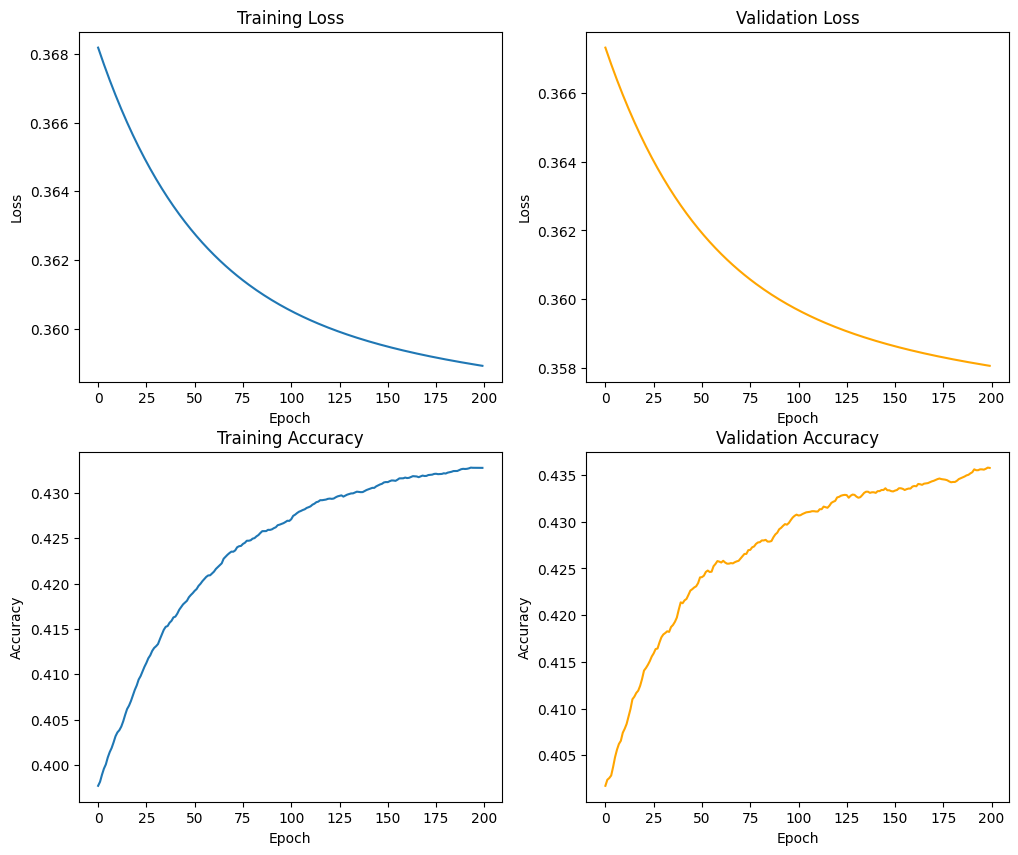

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Biểu đồ Training Loss
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Biểu đồ Validation Loss
ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Biểu đồ Training Accuracy
ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Biểu đồ Validation Accuracy
ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()


In [26]:
# Đánh giá mô hình trên tập validation và test
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)

# In kết quả
print('Evaluation on validation and test set:')
print(f'Validation Accuracy: {val_set_acc:.4f}')
print(f'Test Accuracy: {test_set_acc:.4f}')


Evaluation on validation and test set:
Validation Accuracy: 0.4358
Test Accuracy: 0.4340
